In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, train_df, test_df, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False):
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df, fe_img_name)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def data_fe(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

# def lgb_train(df, debug = False):
#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

# if __name__ == "__main__":
# submission_file_name = "submission_kernel03.csv"
# final_df = data_fe()
# with timer("Full model run"):
#     final_df =  

In [2]:
# final_df.shape

# final_df.dtypes.value_counts()

# single_value_feats = []
# cat_feats = []

# for col in final_df.columns:
#     n = final_df[col].nunique()
#     if n == 1:
#         single_value_feats.append(col)
#     elif n <= 10:
#         cat_feats.append(col)
# #         print(col, n, final_df[col].dtype)
# #         print(final_df[col].value_counts())

# len(single_value_feats), len(cat_feats)

# if 'TARGET' in cat_feats:
#     cat_feats.remove('TARGET')
#     print(len(cat_feats))

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# for col in cat_feats:
#     final_df[col] = le.fit_transform(final_df[col])

# for col in final_df.columns:
#     final_df[col] = final_df[col].astype('category')

# final_df.shape

(356251, 798)

In [21]:
# final_df.drop(single_value_feats, axis=1, inplace=True)

In [7]:
# train_final_df = final_df[final_df['TARGET'].notnull()]
# test_final_df = final_df[final_df['TARGET'].isnull()]
# print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_final_df.shape, test_final_df.shape))

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


In [2]:
train = pd.read_pickle('../../homecreditdata/train_simple_feats_for_sn_typeastest.pkl')
test = pd.read_pickle('../../homecreditdata/test_simple_feats_for_sn.pkl')

In [3]:
train.dtypes.value_counts()

float64    622
uint8      133
int64       42
dtype: int64

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.75514	valid_1's auc: 0.74614
[200]	training's auc: 0.783348	valid_1's auc: 0.767716
[300]	training's auc: 0.802572	valid_1's auc: 0.779971
[400]	training's auc: 0.815185	valid_1's auc: 0.785749
[500]	training's auc: 0.824991	valid_1's auc: 0.788957
[600]	training's auc: 0.833417	valid_1's auc: 0.790661
[700]	training's auc: 0.840711	valid_1's auc: 0.791848
[800]	training's auc: 0.847628	valid_1's auc: 0.792736
[900]	training's auc: 0.853949	valid_1's auc: 0.793394
[1000]	training's auc: 0.859965	valid_1's auc: 0.793967
[1100]	training's auc: 0.865343	valid_1's auc: 0.794148
[1200]	training's auc: 0.870822	valid_1's auc: 0.794477
[1300]	training's auc: 0.875785	valid_1's auc: 0.794583
[1400]	training's auc: 0.880665	valid_1's auc: 0.794669
[1500]	training's auc: 0.885266	valid_1's auc: 0.794596
[1600]	training's auc: 0.889524	valid_1's auc: 0.794404
Early stopping, best iteration is:
[1439]	training's

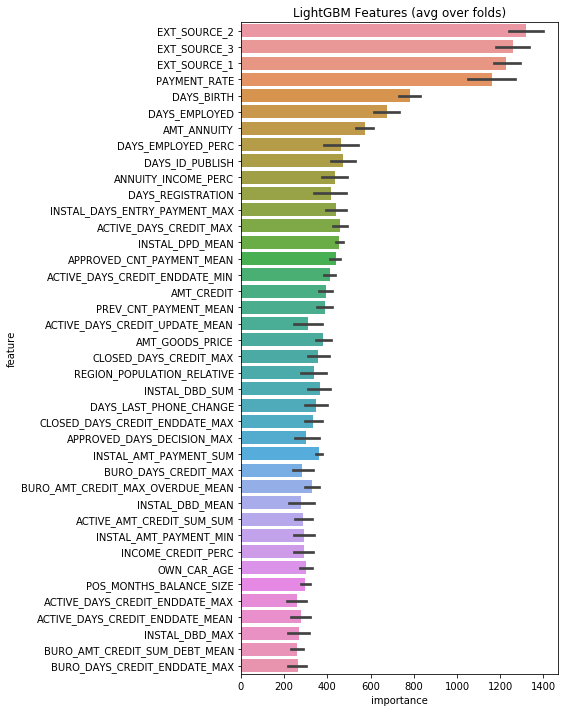

In [4]:
with timer("Run LightGBM with kfold"):
    kfold_lightgbm(None, train, test, 5, 'fe_repro_sub2.csv', 'fe_repro_imp2')

In [8]:
# train_final_df.to_pickle('/home/kai/data/shiyi/homecreditdata/train_simple_feats.pkl')
# test_final_df.to_pickle('/home/kai/data/shiyi/homecreditdata/test_simple_feats.pkl')

In [ ]:
# no cat

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 17s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 26)
Process installments payments - done in 22s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.753991	valid_1's auc: 0.746362
[200]	training's auc: 0.783102	valid_1's auc: 0.767583
[300]	training's auc: 0.802564	valid_1's auc: 0.779506
[400]	training's auc: 0.815397	valid_1's auc: 0.785057
[500]	training's auc: 0.825077	valid_1's auc: 0.78789
[600]	training's auc: 0.833469	valid_1's auc: 0.789726
[700]	training's auc: 0.840821	valid_1's auc: 0.791108
[800]	training's auc: 0.847775	valid_1's auc: 0.792136
[900]	training's auc: 0.854146	valid_1's auc: 0.792602
[1000]	training's auc: 0.859974	valid_1's auc: 0.792702
[1100]	training's auc: 0.865529	valid_1's auc: 0.792988
[1200]	training's auc: 0.870823	valid_1's auc: 0.793244
[1300]	training's auc: 0.875839	valid_1's auc: 0.793368
[1400]	training's auc: 0.880654	valid_1's auc: 0.793581
[1500]	training's auc: 0.885301	valid_1's auc: 0.793559
[1600]	training's auc: 0.889774	valid_1's auc: 0.79351
Early stopping, best iteration is:
[1457]	training's auc: 0.883349	valid_1's auc: 0.793678
Fold  1 AUC : 0.793678
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754751	valid_1's auc: 0.741158
[200]	training's auc: 0.784139	valid_1's auc: 0.762874
[300]	training's auc: 0.803245	valid_1's auc: 0.775055
[400]	training's auc: 0.815744	valid_1's auc: 0.780959
[500]	training's auc: 0.825493	valid_1's auc: 0.784014
[600]	training's auc: 0.83386	valid_1's auc: 0.786017
[700]	training's auc: 0.84119	valid_1's auc: 0.787318
[800]	training's auc: 0.848171	valid_1's auc: 0.788181
[900]	training's auc: 0.85437	valid_1's auc: 0.78867
[1000]	training's auc: 0.860363	valid_1's auc: 0.789099
[1100]	training's auc: 0.865925	valid_1's auc: 0.789607
[1200]	training's auc: 0.871359	valid_1's auc: 0.789914
[1300]	training's auc: 0.87649	valid_1's auc: 0.79011
[1400]	training's auc: 0.881283	valid_1's auc: 0.79022
[1500]	training's auc: 0.88617	valid_1's auc: 0.790269
[1600]	training's auc: 0.890681	valid_1's auc: 0.790339
[1700]	training's auc: 0.894958	valid_1's auc: 0.790284
[1800]	training's auc: 0.899103	valid_1's auc: 0.790222
Early stopping, best iteration is:
[1626]	training's auc: 0.891855	valid_1's auc: 0.790394
Fold  2 AUC : 0.790394
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.755382	valid_1's auc: 0.742839
[200]	training's auc: 0.784211	valid_1's auc: 0.763391
[300]	training's auc: 0.802752	valid_1's auc: 0.77533
[400]	training's auc: 0.815461	valid_1's auc: 0.781021
[500]	training's auc: 0.825216	valid_1's auc: 0.784332
[600]	training's auc: 0.833602	valid_1's auc: 0.786431
[700]	training's auc: 0.841116	valid_1's auc: 0.787878
[800]	training's auc: 0.847885	valid_1's auc: 0.78893
[900]	training's auc: 0.854361	valid_1's auc: 0.789629
[1000]	training's auc: 0.860309	valid_1's auc: 0.790302
[1100]	training's auc: 0.86599	valid_1's auc: 0.790735
[1200]	training's auc: 0.871431	valid_1's auc: 0.791047
[1300]	training's auc: 0.876495	valid_1's auc: 0.791381
[1400]	training's auc: 0.881336	valid_1's auc: 0.791446
[1500]	training's auc: 0.885789	valid_1's auc: 0.791568
[1600]	training's auc: 0.89028	valid_1's auc: 0.791428
[1700]	training's auc: 0.89445	valid_1's auc: 0.791398
Early stopping, best iteration is:
[1548]	training's auc: 0.887984	valid_1's auc: 0.791635
Fold  3 AUC : 0.791635
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.755677	valid_1's auc: 0.742755
[200]	training's auc: 0.784035	valid_1's auc: 0.763493
[300]	training's auc: 0.80332	valid_1's auc: 0.774675
[400]	training's auc: 0.815719	valid_1's auc: 0.780225
[500]	training's auc: 0.825527	valid_1's auc: 0.783688
[600]	training's auc: 0.833941	valid_1's auc: 0.785791
[700]	training's auc: 0.841513	valid_1's auc: 0.787229
[800]	training's auc: 0.848334	valid_1's auc: 0.788246
[900]	training's auc: 0.854657	valid_1's auc: 0.789048
[1000]	training's auc: 0.860653	valid_1's auc: 0.789703
[1100]	training's auc: 0.86629	valid_1's auc: 0.790169
[1200]	training's auc: 0.87154	valid_1's auc: 0.790438
[1300]	training's auc: 0.876674	valid_1's auc: 0.790664
[1400]	training's auc: 0.881554	valid_1's auc: 0.790873
[1500]	training's auc: 0.886207	valid_1's auc: 0.791029
[1600]	training's auc: 0.890445	valid_1's auc: 0.790995
[1700]	training's auc: 0.894579	valid_1's auc: 0.791072
[1800]	training's auc: 0.898575	valid_1's auc: 0.79087
Early stopping, best iteration is:
[1692]	training's auc: 0.894274	valid_1's auc: 0.791094
Fold  4 AUC : 0.791094
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.755001	valid_1's auc: 0.742506
[200]	training's auc: 0.782828	valid_1's auc: 0.76627
[300]	training's auc: 0.802361	valid_1's auc: 0.779295
[400]	training's auc: 0.81506	valid_1's auc: 0.785214
[500]	training's auc: 0.825016	valid_1's auc: 0.788348
[600]	training's auc: 0.833092	valid_1's auc: 0.789992
[700]	training's auc: 0.840699	valid_1's auc: 0.791099
[800]	training's auc: 0.847835	valid_1's auc: 0.792063
[900]	training's auc: 0.854584	valid_1's auc: 0.792745
[1000]	training's auc: 0.860733	valid_1's auc: 0.793012
[1100]	training's auc: 0.866595	valid_1's auc: 0.793277
[1200]	training's auc: 0.871931	valid_1's auc: 0.793399
[1300]	training's auc: 0.876957	valid_1's auc: 0.793713
[1400]	training's auc: 0.881858	valid_1's auc: 0.793827
[1500]	training's auc: 0.886398	valid_1's auc: 0.79378
[1600]	training's auc: 0.891002	valid_1's auc: 0.793768
[1700]	training's auc: 0.895207	valid_1's auc: 0.793895
[1800]	training's auc: 0.899292	valid_1's auc: 0.793865
[1900]	training's auc: 0.903315	valid_1's auc: 0.793945
[2000]	training's auc: 0.907012	valid_1's auc: 0.793901
Early stopping, best iteration is:
[1867]	training's auc: 0.90212	valid_1's auc: 0.794018
Fold  5 AUC : 0.g794018
Full AUC score 0.792147
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Run LightGBM with kfold - done in 1032s
Full model run - done in 1116s

In [ ]:
# yes cat

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754094	valid_1's auc: 0.746378
[200]	training's auc: 0.782891	valid_1's auc: 0.767258
[300]	training's auc: 0.802272	valid_1's auc: 0.779571
[400]	training's auc: 0.815042	valid_1's auc: 0.78515
[500]	training's auc: 0.824951	valid_1's auc: 0.788234
[600]	training's auc: 0.833415	valid_1's auc: 0.790006
[700]	training's auc: 0.840746	valid_1's auc: 0.791384
[800]	training's auc: 0.847789	valid_1's auc: 0.792354
[900]	training's auc: 0.85402	valid_1's auc: 0.792897
[1000]	training's auc: 0.860067	valid_1's auc: 0.793135
[1100]	training's auc: 0.865762	valid_1's auc: 0.793448
[1200]	training's auc: 0.870951	valid_1's auc: 0.793567
[1300]	training's auc: 0.875799	valid_1's auc: 0.793682
[1400]	training's auc: 0.880657	valid_1's auc: 0.793883
[1500]	training's auc: 0.885373	valid_1's auc: 0.793798
[1600]	training's auc: 0.889893	valid_1's auc: 0.793847
Early stopping, best iteration is:
[1433]	training's auc: 0.882321	valid_1's auc: 0.793907
Fold  1 AUC : 0.793907
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.756255	valid_1's auc: 0.742306
[200]	training's auc: 0.784168	valid_1's auc: 0.76311
[300]	training's auc: 0.803148	valid_1's auc: 0.775192
[400]	training's auc: 0.815829	valid_1's auc: 0.780894
[500]	training's auc: 0.825717	valid_1's auc: 0.784062
[600]	training's auc: 0.834064	valid_1's auc: 0.785963
[700]	training's auc: 0.841229	valid_1's auc: 0.787317
[800]	training's auc: 0.848219	valid_1's auc: 0.788299
[900]	training's auc: 0.854648	valid_1's auc: 0.788893
[1000]	training's auc: 0.860778	valid_1's auc: 0.789228
[1100]	training's auc: 0.866363	valid_1's auc: 0.789687
[1200]	training's auc: 0.871847	valid_1's auc: 0.789838
[1300]	training's auc: 0.877104	valid_1's auc: 0.789892
[1400]	training's auc: 0.882044	valid_1's auc: 0.790139
[1500]	training's auc: 0.886848	valid_1's auc: 0.790317
[1600]	training's auc: 0.891373	valid_1's auc: 0.790193
Early stopping, best iteration is:
[1482]	training's auc: 0.885961	valid_1's auc: 0.790347
Fold  2 AUC : 0.790347
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.755079	valid_1's auc: 0.742667
[200]	training's auc: 0.783962	valid_1's auc: 0.763328
[300]	training's auc: 0.802746	valid_1's auc: 0.775453
[400]	training's auc: 0.815464	valid_1's auc: 0.781076
[500]	training's auc: 0.825297	valid_1's auc: 0.784476
[600]	training's auc: 0.833626	valid_1's auc: 0.786375
[700]	training's auc: 0.841031	valid_1's auc: 0.787796
[800]	training's auc: 0.847944	valid_1's auc: 0.788829
[900]	training's auc: 0.854528	valid_1's auc: 0.789627
[1000]	training's auc: 0.860223	valid_1's auc: 0.790322
[1100]	training's auc: 0.865782	valid_1's auc: 0.790646
[1200]	training's auc: 0.871207	valid_1's auc: 0.790885
[1300]	training's auc: 0.876235	valid_1's auc: 0.791205
[1400]	training's auc: 0.880951	valid_1's auc: 0.791271
[1500]	training's auc: 0.885526	valid_1's auc: 0.791332
[1600]	training's auc: 0.889964	valid_1's auc: 0.791357
[1700]	training's auc: 0.894227	valid_1's auc: 0.791372
[1800]	training's auc: 0.898329	valid_1's auc: 0.791472
[1900]	training's auc: 0.901962	valid_1's auc: 0.791627
[2000]	training's auc: 0.905667	valid_1's auc: 0.791664
[2100]	training's auc: 0.909473	valid_1's auc: 0.791675
Early stopping, best iteration is:
[1958]	training's auc: 0.904123	valid_1's auc: 0.791745
Fold  3 AUC : 0.791745
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.755643	valid_1's auc: 0.742408
[200]	training's auc: 0.783997	valid_1's auc: 0.763435
[300]	training's auc: 0.803229	valid_1's auc: 0.774589
[400]	training's auc: 0.815705	valid_1's auc: 0.780009
[500]	training's auc: 0.825434	valid_1's auc: 0.783112
[600]	training's auc: 0.833539	valid_1's auc: 0.785133
[700]	training's auc: 0.841306	valid_1's auc: 0.786631
[800]	training's auc: 0.848251	valid_1's auc: 0.787863
[900]	training's auc: 0.854594	valid_1's auc: 0.788547
[1000]	training's auc: 0.860507	valid_1's auc: 0.789021
[1100]	training's auc: 0.866112	valid_1's auc: 0.789606
[1200]	training's auc: 0.871399	valid_1's auc: 0.789831
[1300]	training's auc: 0.87658	valid_1's auc: 0.79008
[1400]	training's auc: 0.881574	valid_1's auc: 0.790344
[1500]	training's auc: 0.886243	valid_1's auc: 0.790448
[1600]	training's auc: 0.890433	valid_1's auc: 0.7906
[1700]	training's auc: 0.894535	valid_1's auc: 0.790593
[1800]	training's auc: 0.898483	valid_1's auc: 0.790705
[1900]	training's auc: 0.902622	valid_1's auc: 0.79062
Early stopping, best iteration is:
[1777]	training's auc: 0.897566	valid_1's auc: 0.790767
Fold  4 AUC : 0.790767
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754337	valid_1's auc: 0.741638
[200]	training's auc: 0.782851	valid_1's auc: 0.766202
[300]	training's auc: 0.802246	valid_1's auc: 0.77885
[400]	training's auc: 0.815044	valid_1's auc: 0.784784
[500]	training's auc: 0.824832	valid_1's auc: 0.788053
[600]	training's auc: 0.833021	valid_1's auc: 0.789772
[700]	training's auc: 0.840864	valid_1's auc: 0.791119
[800]	training's auc: 0.84789	valid_1's auc: 0.792118
[900]	training's auc: 0.85463	valid_1's auc: 0.792644
[1000]	training's auc: 0.860708	valid_1's auc: 0.792727
[1100]	training's auc: 0.866344	valid_1's auc: 0.793078
[1200]	training's auc: 0.871533	valid_1's auc: 0.793319
[1300]	training's auc: 0.876404	valid_1's auc: 0.793505
[1400]	training's auc: 0.881215	valid_1's auc: 0.793617
[1500]	training's auc: 0.885841	valid_1's auc: 0.793648
[1600]	training's auc: 0.890441	valid_1's auc: 0.793812
[1700]	training's auc: 0.894567	valid_1's auc: 0.793863
[1800]	training's auc: 0.898718	valid_1's auc: 0.793796
[1900]	training's auc: 0.902707	valid_1's auc: 0.79375
[2000]	training's auc: 0.906354	valid_1's auc: 0.793674
Early stopping, best iteration is:
[1864]	training's auc: 0.901299	valid_1's auc: 0.793905
Fold  5 AUC : 0.793905
Full AUC score 0.792129
/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Run LightGBM with kfold - done in 1055s

In [20]:
(0.794018+0.791094+0.791635+0.790394+0.793678)/5

0.7921638

In [21]:
# with explicit cat feats
(0.793905+0.790767+0.791745+0.790347+0.793907)/5

0.7921342